In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random
from collections import OrderedDict

In [2]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}

In [3]:
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
file2exercise = {"../alphapose_res/irimi_tenkan_kps.json":"ирими тенкан", 
                 "../alphapose_res/ta_tracking.json":"цуги аши",
                 "../alphapose_res/utmt_kps.json":"уширо тенкан мае тенкан"}
single_st_ann = "../data/single_student_annotations.json"

SEQ_LEN_FRAMES = 256
CHANNELS = 3
SEED = 42
BATCH_FIRST = True

# Подготовка данных

In [4]:
from dataproc import *
from train_utils import * 

In [5]:
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                            "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
student_exercise_points, exercise_borders = parse_borders_annotations(file2mapping, single_st_ann, 
                                                                      annotations_map, ss_vid_ann, 
                                                                      single_student_tids)
frame_durs = [stex.shape[1] for stex in student_exercise_points]
encoded_borders = encode_borders(exercise_borders, frame_durs, "<EXERCISE_BODY>")
split_exercs, split_borders = split_into_equal_frame_len(student_exercise_points, encoded_borders, SEQ_LEN_FRAMES, drop_last=False)

## Датасет

In [7]:
default_feature_flatten = lambda x: np.transpose(x, (1, 0, 2)).reshape(SEQ_LEN_FRAMES, -1)

def encode_border_label(border_label_vec, total_borders_len):
    container = np.zeros((len(border_label_vec), total_borders_len), dtype=np.float32)
    for i, label in enumerate(border_label_vec):
        container[i, label] = 1
    return container

class FrameTaggingDataset(Dataset):
    def __init__(self, inputs:list, tag_vec:list, channel_count:int, sequence_length:int,
                 border_tags_count:int, feature_flatten_fn=default_feature_flatten, batch_first:bool=False):
        self.inputs = inputs
        self.tag_vecs = tag_vec
        self.channels = channel_count
        self.batch_first = batch_first
        self.seq_len = sequence_length
        assert feature_flatten_fn != None
        self.feature_flatten = feature_flatten_fn
        self.border_tags_count = border_tags_count
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        img = self.inputs[idx]
        img = img[:, :, :self.channels] 
        vectorized_seq = self.feature_flatten(img).astype('float32')
        encoded_labels = encode_border_label(self.tag_vecs[idx], self.border_tags_count)
        if not self.batch_first:
            vectorized_seq = vectorized_seq.reshape(self.seq_len, 1, -1)       
        return vectorized_seq, encoded_labels #.astype('float32')

In [8]:
# how to split to train/test/validation ?
random.seed(SEED)
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

train_ids, test_ids, val_ids = [], [], []
train_xs, train_tags = [], []
test_xs, test_tags = [], []
val_xs, val_tags = [], []

for s in split_exercs:
    for i, student_frames in enumerate(split_exercs[s]):
        rval = random.random()
        if rval <= train_frac:
            train_xs.append(student_frames)
            train_tags.append(split_borders[s][i])
            train_ids.append((s, i))
        elif rval <= (train_frac + test_frac):
            test_xs.append(student_frames)
            test_tags.append(split_borders[s][i])
            test_ids.append((s, i))
        else:
            val_xs.append(student_frames)
            val_tags.append(split_borders[s][i])
            val_ids.append((s, i))

total_data_count = len(train_xs) + len(test_xs) + len(val_xs)

print("Total", total_data_count)
print("Train count", len(train_xs))
print("Test count", len(test_xs))
print("Val count", len(val_xs))

Total 209
Train count 151
Test count 37
Val count 21


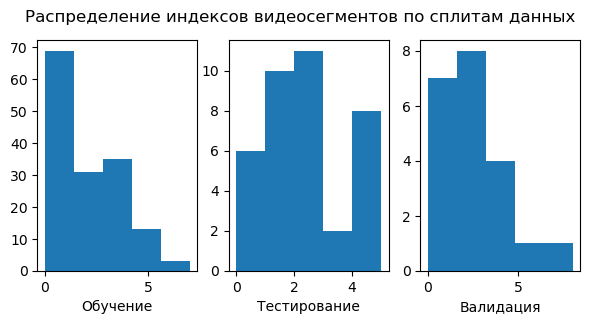

In [9]:
train_segment_idx = [f[-1] for f in train_ids]
test_segment_idx = [f[-1] for f in test_ids]
val_segment_idx = [f[-1] for f in val_ids]

train_hist_data = np.histogram(train_segment_idx, 5)
test_hist_data = np.histogram(test_segment_idx, 5)
val_segment_idx = np.histogram(val_segment_idx, 5)

fig, axs = plt.subplots(1, 3, figsize=(7, 3))
axs[0].stairs(train_hist_data[0], train_hist_data[1], fill=True)
axs[0].set_xlabel("Обучение")
axs[1].stairs(test_hist_data[0], test_hist_data[1], fill=True)
axs[1].set_xlabel("Тестирование")
axs[2].stairs(val_segment_idx[0], val_segment_idx[1], fill=True)
axs[2].set_xlabel("Валидация")
fig.suptitle('Распределение индексов видеосегментов по сплитам данных')
plt.show()

In [10]:
train_ds = FrameTaggingDataset(train_xs, train_tags, CHANNELS, SEQ_LEN_FRAMES, len(EXTOKENS), batch_first=BATCH_FIRST)
val_ds = FrameTaggingDataset(val_xs, val_tags, CHANNELS, SEQ_LEN_FRAMES, len(EXTOKENS), batch_first=BATCH_FIRST)
test_ds = FrameTaggingDataset(test_xs, test_tags, CHANNELS, SEQ_LEN_FRAMES, len(EXTOKENS), batch_first=BATCH_FIRST)

batch_size = 32
if BATCH_FIRST:
    collate_func = torch.utils.data.default_collate
else:
    collate_func = batch_second_collate
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_func)
val_loader = DataLoader(val_ds, 1, collate_fn=collate_func)
test_loader = DataLoader(test_ds, 1, shuffle=False, collate_fn=collate_func)

# Обучение

## Модель

In [11]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging
class FrameTaggerModel(torch.nn.Module):
    def __init__(self, input_dim:int, tagset_size:int, seq_len:int, batch_first:bool, hidden_size:int=100, recurrent_layers:int=5):
        super(FrameTaggerModel, self).__init__()
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.recurrent = torch.nn.LSTM(input_dim, hidden_size, num_layers=recurrent_layers, batch_first=batch_first)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, tagset_size),
            torch.nn.LogSoftmax(1)
        )
        
    def forward(self, xb):
        if len(xb.shape)==2: # one example
            seq_len = xb.shape[0]
            lstm_out, _ = self.recurrent(xb)
            return self.fc(lstm_out.reshape(self.seq_len, -1))
        else: #batch
            if self.batch_first:
                tagsets = []
                for bidx in range(xb.shape[0]):
                    lstm_out, _ = self.recurrent(xb[bidx, :, :].view(self.seq_len, -1))
                    tagsets.append(self.fc(lstm_out))
                return torch.stack(tagsets)                    
            else:
                tagsets = []
                for bidx in range(xb.shape[1]):
                    item_hidden = self.recurrent(xb[:, bidx, :].view(self.seq_len, -1))
                    tagsets.append(self.fc(item_hidden))
                return torch.stack(tagsets)
        # if not self.batch_first or len(xb.shape)==2:
        #     seq_len = xb.shape[0]
        # else:
        #     seq_len = xb.shape[1]
        
        # lstm_out, _ = self.recurrent(xb)
        # tag_scores = self.fc(lstm_out.reshape(self.seq_len, -1))
        # return tag_scores

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
        
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

cuda


In [12]:
test_input = torch.rand(SEQ_LEN_FRAMES, 26 * CHANNELS)
tester = FrameTaggerModel(26 * CHANNELS, len(EXTOKENS), SEQ_LEN_FRAMES, BATCH_FIRST, hidden_size=10)
output = tester(test_input)
print(output.shape)
np.argmax(output.detach().numpy(), 1).shape

torch.Size([256, 6])


(256,)

In [13]:
another = torch.rand(32, SEQ_LEN_FRAMES, 26 * CHANNELS)
stuff, (_, _) = tester.recurrent(another)
print(stuff.shape)
out_another = tester(another)
out_another.shape

torch.Size([32, 256, 10])


torch.Size([32, 256, 6])

In [14]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

inprogress_metrics = {"F1":F_score}

def calc_metrics(preds, targets, inprogress_metrics):
    report = dict()
    for metric in inprogress_metrics:
        metric_func = inprogress_metrics[metric]
        mval = metric_func(preds, targets)
        report[metric] = round(mval.item(), 3)
    return report

def print_report(loss_value, metric_vals, beginning):
    addition = []
    for km in metric_vals:
        formatteds = f"{km}: {metric_vals[km]} "
        addition.append(formatteds)    
    print(beginning, "Loss:", loss_value, "".join(addition))

def train_one_epoch(model:torch.nn.Module, criterion, optimizer, data_loader:DeviceDataLoader):
    model.train()
    running_losses = []
    for i, (image, target) in enumerate(data_loader):        
        optimizer.zero_grad()
        out = model(image)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step() 
        running_losses.append(loss)
    return torch.stack(running_losses).mean().item()
    
def evaluate(model, val_data_loader:DeviceDataLoader, criterion=F.binary_cross_entropy):
    model.eval() 
    running_losses = []
    running_fscore = []
    with torch.no_grad():
        for i, (image, target) in tqdm(enumerate(val_data_loader)):
            out = model(image)
            loss = criterion(out, target)
            running_losses.append(loss.detach())
            running_fscore.append(F_score(out, target).detach())
    l = torch.stack(running_losses).mean().item()
    fs = torch.stack(running_fscore).mean().item()
    return l, fs

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, criterion=F.binary_cross_entropy):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        train_loss = train_one_epoch(model, criterion, optimizer, train_loader)
        # Validation phase
        val_loss, val_score = evaluate(model, val_loader, criterion)
        result = {'train_loss':train_loss, 'val_loss':val_loss, 'val_score':val_score}
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))
        history.append(result)
    return history

In [15]:
model = to_device(FrameTaggerModel(26*CHANNELS, len(EXTOKENS), SEQ_LEN_FRAMES, BATCH_FIRST, hidden_size=10), device)
epochs = 100
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [16]:
for b in train_dl:
    #print(b[0].shape)
    print(model(b[0]).shape)
    break

torch.Size([32, 256, 6])


In [17]:
history = fit(epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED